# **<center><font style="color:rgb(100,109,254)">Module 2: Real-Time Controllable Face Makeup</font> </center>**

<img src='https://drive.google.com/uc?export=download&id=1ERLn4WIEsSGnAO_4LDT8R8FTf6ac3f5n'>

## **<font style="color:rgb(134,19,348)"> Module Outline </font>**

The module can be split into the following parts:

- *Lesson 1: Introduction to Face Landmark Detection Theory*

- ***Lesson 2:* Create a Face Landmarks Detector** *(This Tutorial)*

- *Lesson 3: Build a Face Part Selector*

- *Lesson 4: Build a Virtual Face Makeup Application*

- *Lesson 5: Build the Final Application*

**Please Note**, these Jupyter Notebooks are not for sharing; do read the Copyright message below the Code License Agreement section which is in the last cell of this notebook.
-Taha Anwar

Alright, let's get started.

### **<font style="color:rgb(134,19,348)"> Import the Libraries</font>**

First, we will import the required libraries.

In [1]:
import cv2
import numpy as np
import mediapipe as mp
from time import time
import matplotlib.pyplot as plt
from importlib.metadata import version
print(f"Mediapipe version: {version('mediapipe')}, it should be 0.8.9.1")

Mediapipe version: 0.8.10.1, it should be 0.8.9.1


## **<font style="color:rgb(134,19,348)">Initialize the Face Landmarks Detection Model</font>**

To use the Mediapipe's Face Mesh solution, we first have to initialize the face mesh class using the syntax **`mp.solutions.face_mesh`** and then we will have to call the function **`mp.solutions.face_mesh.FaceMesh()`** with the arguments explained below:

* **`static_image_mode`** - It is a boolean value that is if set to `False`, the solution treats the input images as a video stream. It will try to detect faces in the first input images, and upon a successful detection further localizes the face landmarks. In subsequent images, once all **`max_num_faces`** faces are detected and the corresponding face landmarks are localized, it simply tracks those landmarks without invoking another detection until it loses track of any of the faces. This reduces latency and is ideal for processing video frames. If set to `True`, face detection runs on every input image, ideal for processing a batch of static, possibly unrelated, images. Its default value is `False`.


* **`max_num_faces`** - It is the maximum number of faces to detect. Its default value is `1`.


* **`refine_landmarks`** - It is a boolean value that is if set to `True`, the solution further refines the landmark coordinates around the eyes and lips, and output additional landmarks around the irises by applying the [Attention Mesh Model](https://google.github.io/mediapipe/solutions/face_mesh#attention-mesh-model). Its default value is `False`.


* **`min_detection_confidence`** - It is the minimum detection confidence `([0.0, 1.0])` required to consider the face-detection model's prediction correct. Its default value is `0.5` which means that all the detections with prediction confidence less than 50% are ignored by default. 


* **`min_tracking_confidence`** - It is the minimum tracking confidence `([0.0, 1.0])` from the landmark-tracking model for the face landmarks to be considered tracked successfully, or otherwise face detection will be invoked automatically on the next input image, so increasing its value increases the robustness, but also increases the latency. It is ignored if **`static_image_mode`** is `True`, where face detection simply runs on every image. Its default value is `0.5`.

We will be working with images and videos as well, so we will have to set up the **`mp.solutions.face_mesh.FaceMesh()`** function two times. Once with the argument **`static_image_mode`** set to `True` to use with images and the second time **`static_image_mode`** set to `False` to use with videos. We will also need to initialize the **`mp.solutions.drawing_utils`** class and the **`mp.solutions.drawing_styles`** class that will allow us to visualize the landmarks on the images/frames in different drawing styles provided by Mediapipe.

In [2]:
# Initialize the mediapipe face mesh class.
mp_face_mesh = mp.solutions.face_mesh

# Set up the face landmarks function for images.
face_mesh_images = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=2,
                                         refine_landmarks=True, min_detection_confidence=0.5)

# Set up the face landmarks function for videos.
face_mesh_videos = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, 
                                         refine_landmarks=True, min_detection_confidence=0.5,
                                         min_tracking_confidence=0.3)

# Initialize the mediapipe drawing class.
mp_drawing = mp.solutions.drawing_utils

# Initialize the mediapipe drawing styles class.
mp_drawing_styles = mp.solutions.drawing_styles

## **<font style="color:rgb(134,19,348)">Create a Face Landmarks Detection Function</font>**

Now similar to what we had done in the previous module for the hands' landmarks detection, we will create a function **`detectFacialLandmarks()`** that will perform Face(s) landmarks detection on an image and will visualize the resultant image along with the original image (using the [**`matplotlib`**](https://matplotlib.org/stable/index.html) library) or return the resultant image along with the output of the model depending upon the passed arguments.

To perform the Face(s) landmarks detection, we will pass the image to the Face's landmarks detection machine learning pipeline by using the function **`mp.solutions.face_mesh.FaceMesh().process()`**. But first, we will have to convert the image from **`BGR`** to **`RGB`** format using the function [**`cv2.cvtColor()`**](https://docs.opencv.org/3.4/d8/d01/group__imgproc__color__conversions.html#ga397ae87e1288a81d2363b61574eb8cab) as OpenCV reads images in **`BGR`** format and the ml pipeline expects the input images to be in **`RGB`** color format.

The machine learning pipeline outputs an object that has an attribute **`multi_face_landmarks`** that contains the **468 3D** facial landmarks for each detected face in the image. Each landmark has:

* **`x`** - It is the landmark x-coordinate normalized to [0.0, 1.0] by the image width.

* **`y`** - It is the landmark y-coordinate normalized to [0.0, 1.0] by the image height.

* **`z`** - It is the landmark z-coordinate normalized to roughly the same scale as **`x`**. It represents the landmark depth with the center of the head being the origin, and the smaller the value is, the closer the landmark is to the camera. 

**Note:** *The z-coordinate is just the relative distance of the landmark from the center of the head, and this distance increases and decreases depending upon the distance from the camera so that is why it represents the depth of each landmark point.*

The image below shows the **four hundred sixty-eight** Face landmarks, that this solution detects, along with their indexes. 

<center>
    
<img src='https://drive.google.com/uc?export=download&id=1wOuAzZfXKJ1OZhE94PqGbv4ab1fPEZJy' width = 600> <br>
<a href="https://developers.google.com/ar/develop/augmented-faces">Image Source</a>

</center>

We will draw the detected landmarks on a copy of the input image using the function **`mp.solutions.drawing_utils.draw_landmarks()`** from the class **`mp.solutions.drawing_utils`**, we had initialized earlier.

In [3]:
def detectFacialLandmarks(image, face_mesh, draw=True, display = True):
    '''
    This function performs facial landmarks detection on an image.
    Args:
        image:     The input image of person(s) whose facial landmarks needs to be detected.
        face_mesh: The Mediapipe's face landmarks detection function required to perform the landmarks detection.
        draw:      A boolean value that is if set to true the function draws Face(s) landmarks on the output image. 
        display:   A boolean value that is if set to true the function displays the original input image, 
                   and the output image with the face landmarks drawn and returns nothing.
    Returns:
        output_image:   A copy of input image with face landmarks drawn.
        face_landmarks: An array containing the face landmarks (x and y coordinates) of a face in the image.
    '''
    
    # Get the height and width of the input image.
    height, width, _ = image.shape
    
    # Initialize an array to store the face landmarks.
    face_landmarks = np.array([])
    
    # Create a copy of the input image to draw facial landmarks.
    output_image = image.copy()
    
    # Convert the image from BGR into RGB format.
    imgRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Perform the facial landmarks detection on the image.
    results = face_mesh.process(imgRGB)
    
    # Check if facial landmarks are found. 
    if results.multi_face_landmarks:

        # Iterate over the found faces.
        for face in results.multi_face_landmarks:
            
            # Convert the Face landmarks x and y coordinates into their original scale,
            # And store them into a numpy array.
            # For simplicity, we are only storing face landmarks of a single face, 
            # you can extend it to work with multiple faces if you want.
            face_landmarks = np.array([(landmark.x*width, landmark.y*height)
                                        for landmark in face.landmark], dtype=np.int32)
            
            # Check if facial landmarks are specified to be drawn.
            if draw:

                # Draw the facial landmarks on the output image with the face mesh tesselation
                # connections using default face mesh tesselation style.
                mp_drawing.draw_landmarks(image=output_image, landmark_list=face,
                                          connections=mp_face_mesh.FACEMESH_TESSELATION,
                                          landmark_drawing_spec=None, 
                                          connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style())

                # Draw the facial landmarks on the output image with the face mesh contours
                # connections using default face mesh contours style.
                mp_drawing.draw_landmarks(image=output_image, landmark_list=face,
                                          connections=mp_face_mesh.FACEMESH_CONTOURS,
                                          landmark_drawing_spec=None, 
                                          connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style())

    # Check if the original input image and the output image are specified to be displayed.
    if display:
        
        # Display the original input image and the output image.
        plt.figure(figsize=[15,15])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Sample Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
    # Otherwise
    else:
        
        # Return the output image and landmarks returned by the detector.
        return output_image, face_landmarks               

Now we will read a few sample images using the function [**`cv2.imread()`**](https://docs.opencv.org/3.4/d4/da8/group__imgcodecs.html#ga288b8b3da0892bd651fce07b3bbd3a56) and then utilize the function **`detectFacialLandmarks()`** created above to perform Face landmarks detection on the images and visualize the results.

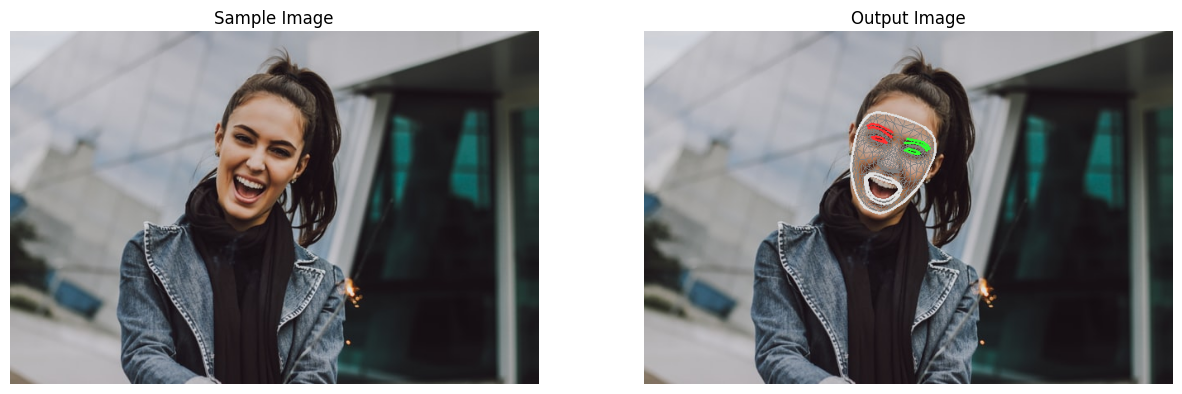

In [4]:
# Read a sample image and perform facial landmarks detection on it.
image = cv2.imread('media/sample1.jpg')
detectFacialLandmarks(image, face_mesh_images, display=True)

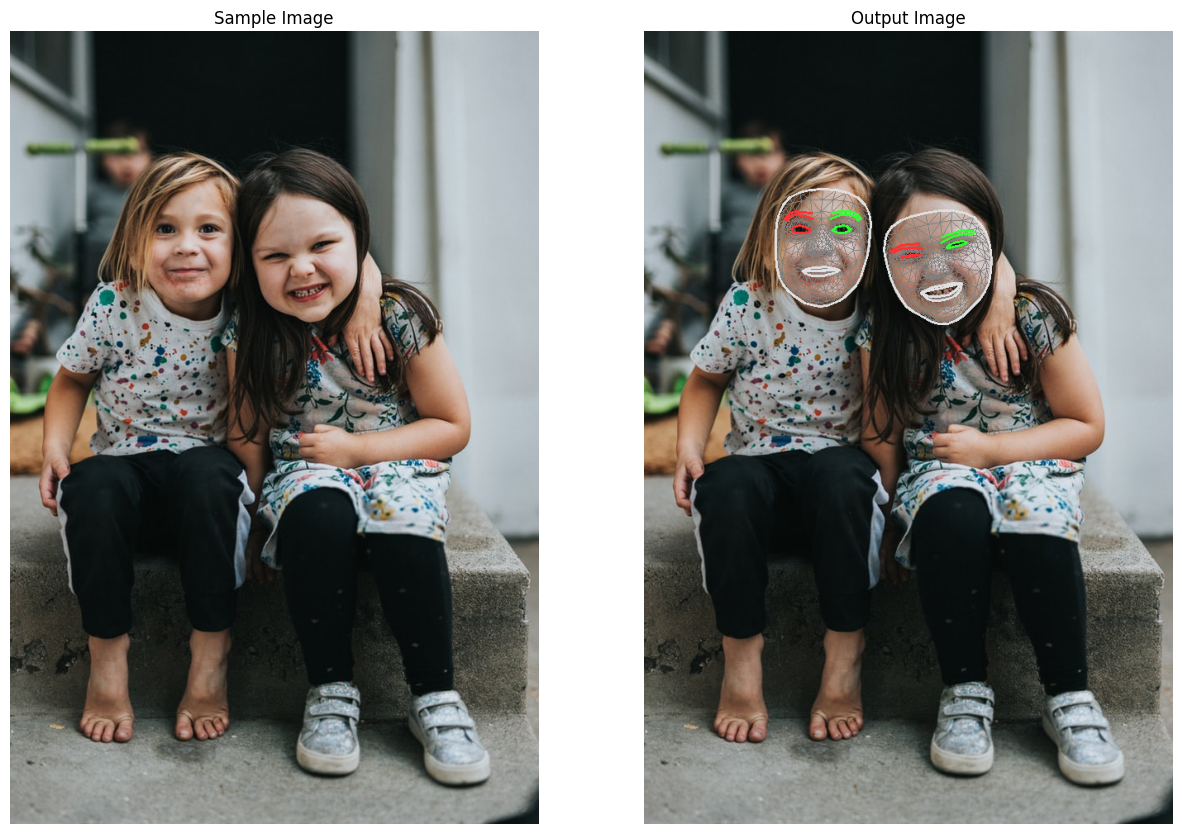

In [5]:
# Read another sample image and perform facial landmarks detection on it.
image = cv2.imread('media/sample2.jpg')
detectFacialLandmarks(image, face_mesh_images, display=True)

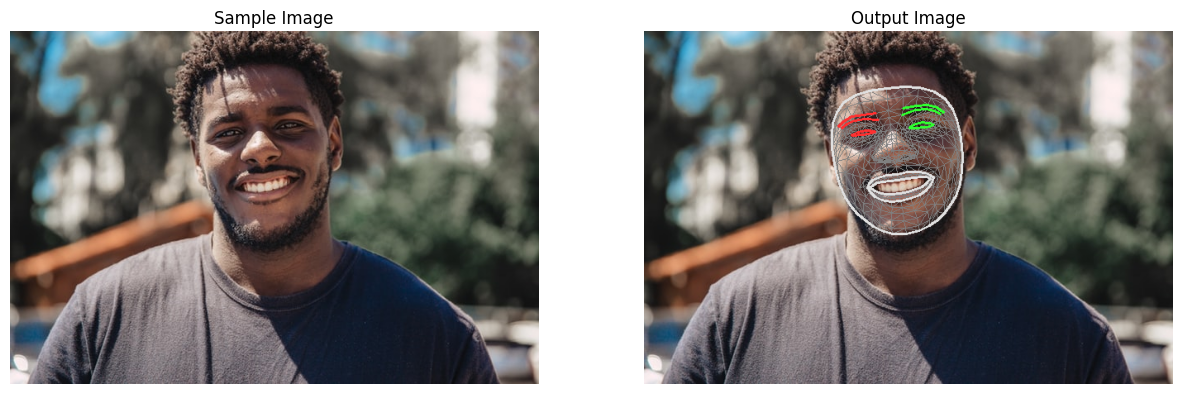

In [6]:
# Read another sample image and perform facial landmarks detection on it.
image = cv2.imread('media/sample3.jpg')
detectFacialLandmarks(image, face_mesh_images, display=True)


The results are remarkable on the images, now let's try the function on a real-time webcam feed. We will also calculate and display the average frames per second to get an idea of whether this solution can work in real-time on a CPU or not.

In [7]:
# Initialize the VideoCapture object to read from the webcam.
camera_video = cv2.VideoCapture(0, cv2.CAP_DSHOW)

# Remove these
#camera_video.set(3,1280)
#camera_video.set(4,960)

# Create named window for resizing purposes.
cv2.namedWindow('Face Landmarks Detection', cv2.WINDOW_NORMAL)

# Get the start time.
start_time = time()

# Initialize a variable to store the frame count.
frame_count = 0

# Iterate until the webcam is accessed successfully.
while camera_video.isOpened():
    
    # Read a frame.
    ok, frame = camera_video.read()
    
    # Check if frame is not read properly then continue to the next iteration to read the next frame.
    if not ok:
        continue
    
    # Increment the frame counter.
    frame_count += 1
        
    # Get the height and width of the frame of the webcam video.
    frame_height, frame_width, _ = frame.shape
    
    # Flip the frame horizontally for natural (selfie-view) visualization.
    frame = cv2.flip(frame, 1)
    
    # Perform Face landmarks detection.
    frame, _ = detectFacialLandmarks(frame, face_mesh_videos, display=False)
    
    # Calaculate average frames per second.
    ##################################################################################################
    
    # Get the current time.
    curr_time = time()
    
    # Check if the difference between the start and current time > 0 to avoid division by zero.
    if (curr_time - start_time) > 0:
    
        # Calculate the average number of frames per second.
        frames_per_second = frame_count // (curr_time - start_time)
        
        # Write the calculated number of frames per second on the frame. 
        cv2.putText(frame, 'FPS: {}'.format(int(frames_per_second)), (10, int(frame_width/25)),
                    cv2.FONT_HERSHEY_PLAIN, int(frame_width/300), (0, 255, 0), int(frame_width/200))
    
    ##################################################################################################
           
    # Display the frame.
    cv2.imshow('Face Landmarks Detection', frame)
    
    # Wait for 1ms. If a key is pressed, retreive the ASCII code of the key.
    k = cv2.waitKey(1) & 0xFF
    
    # Check if 'ESC' is pressed and break the loop.
    if(k == 27):
        break

# Release the VideoCapture Object and close the windows.
camera_video.release()
cv2.destroyAllWindows()


# Additional comments:
#       - This program takes in the video frame, and checks for a face
#         If there is a face, the program will take the face landmarks,
#         and connect it using the tesse style. Furthermore, depending
#         on the range of face landmarks, the color will be adjusted.
#         

Impressive! the solution is fast even on a CPU and accurate as well.

**Note:** *If you're interested in things like Face Expression Recognition and Snapchat-like Face Filters Controlled by Facial Expressions, then watch [this tutorial](https://www.youtube.com/watch?v=QERl1-ckFr8&t=955s)*.


##  <font style="color:rgb(34,169,134)">Challenge (Optional)</font>

Create a simple python script that will take in a directory path and will perform Face Landmarks Detection on all the images inside that directory and share the results with me in the discussion Forum.

**Hint:** You can use the [**`os.path.listdir()`**](https://docs.python.org/3/library/os.html#os.listdir) function to get the images names inside the directory.

In [8]:
## ADD CODE HERE

### **<font style="color:rgb(255,140,0)"> Code License Agreement </font>**
```
Copyright (c) 2022 Bleedai.com

Feel free to use this code for your own projects commercial or noncommercial, these projects can be Research-based, just for fun, for-profit, or even Education with the exception that you’re not going to use it for developing a course, book, guide, or any other educational products.

Under *NO CONDITION OR CIRCUMSTANCE* you may use this code for your own paid educational or self-promotional ventures without written consent from Taha Anwar (BleedAI.com).

```
